In [1]:
import matplotlib as mpl
from utils import plot, softmax
import matplotlib.pyplot as plt
import numpy as np
import _pickle as pkl
import scipy.stats as stats
import tensorflow as tf
import time
import scipy
from ig_attack import IntegratedGradientsAttack
from utils import dataReader, get_session, integrated_gradients
from model import Model

tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
X, y = dataReader()

In [3]:
# load class semantics 
classes = []
with open('class_semantics.txt') as f:
    for line in f:
        classes.append(line.replace('\n',''))

Image ID: 1000, Image Label : No entry


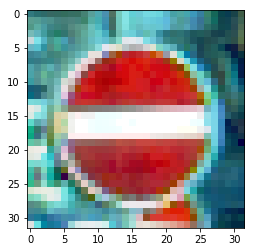

In [4]:
n = 1000
original_label = y[n]
test_image = X[n]
plt.rcParams["figure.figsize"]=8,8
print("Image ID: {}, Image Label : {}".format(n, classes[y[n]]))
%matplotlib inline
plt.imshow(X[n])

In [5]:
tf.reset_default_graph()
sess = get_session()
model = Model(create_saliency_op = 'ig')
# restore models
model_dir = 'models/nat_trained'

saver = tf.train.Saver()
checkpoint = tf.train.latest_checkpoint(model_dir)
saver.restore(sess, checkpoint)

In [6]:
k_top = 100 #Recommended for ImageNet
eval_k_top = 100
num_steps = 100 #Number of steps in Integrated Gradients Algorithm (refer to the original paper)
attack_method = 'topK'
epsilon = 8.0 #Maximum allowed perturbation for each pixel
attack_steps = 100
attack_times = 1
alpha = 2.0
attack_measure = "kendall"
reference_image = np.zeros((32, 32, 3)) #Our chosen reference(the mean image)

module = IntegratedGradientsAttack(sess = sess, test_image = test_image, 
                                   original_label = original_label, NET = model,
                                   attack_method = attack_method, epsilon = epsilon,
                                   k_top = k_top, eval_k_top = eval_k_top, num_steps = num_steps,
                                   attack_iters = attack_steps,
                                   attack_times = attack_times,
                                   alpha = alpha,  
                                   attack_measure = attack_measure,
                                   reference_image = reference_image, 
                                   same_label = True)

In [7]:
output = module.iterative_attack_once()

print('''For maximum allowed perturbation size equal to {}, the resulting perturbation size was equal to {}
        '''.format(epsilon, np.max(np.abs(test_image - module.perturbed_image))))

print('''{} % of the {} most salient pixels in the original image are among {} most salient pixels of the 
perturbed image'''.format(output[0]*100, eval_k_top, eval_k_top))

print("The spearman rank correlation between salieny maps is equal to {}".format(output[1]))

print("The kendall rank correlation between salieny maps is equal to {}".format(output[2]))

nat_prediction = sess.run(model.prediction, feed_dict={model.input: [test_image], model.label: [original_label]})
adv_prediction = sess.run(model.prediction, feed_dict={model.input: [module.perturbed_image], model.label: [original_label]})
print('nat_prediction: %s, adv_prediction: %s'%(int(nat_prediction), int(adv_prediction)))

For maximum allowed perturbation size equal to 8.0, the resulting perturbation size was equal to 8
        
43.0 % of the 100 most salient pixels in the original image are among 100 most salient pixels of the 
perturbed image
The spearman rank correlation between salieny maps is equal to 0.7932583282669335
The kendall rank correlation between salieny maps is equal to 0.6160228800097751
nat_prediction: 17, adv_prediction: 17


In [8]:
nat_output = sess.run(model.output_with_relu, feed_dict={model.input: [test_image]})
nat_pred = softmax(nat_output)
adv_output = sess.run(model.output_with_relu, feed_dict={model.input: [module.perturbed_image]})
adv_pred = softmax(adv_output)
print('original prediction: {}, confidence: {}'.format(classes[np.argmax(nat_pred)], np.max(nat_pred)))
print('perturbed prediction: {}, confidence: {}'.format(classes[np.argmax(adv_pred)], np.max(adv_pred)))

original prediction: No entry, confidence: 1.0
perturbed prediction: No entry, confidence: 1.0


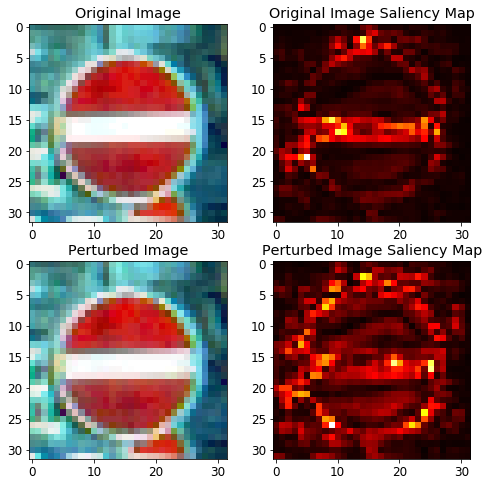

In [9]:
original_IG = integrated_gradients(sess, reference_image, test_image, original_label, model, gradient_func='output_input_gradient', steps=num_steps)

mpl.rcParams["figure.figsize"]=8,8
plt.rc("text",usetex=False)
plt.rc("font",family="sans-serif",size=12)
saliency = np.sum(np.abs(original_IG),-1)
original_saliency = 32*32*saliency/np.sum(saliency)
plt.subplot(2,2,1)
plt.title("Original Image")
image = X[n].astype(np.uint8)
plt.imshow(image)
plt.subplot(2,2,2)
plt.title("Original Image Saliency Map")
plt.imshow(original_saliency, cmap="hot")

perturbed_IG = integrated_gradients(sess, reference_image, module.perturbed_image, original_label, model, gradient_func='output_input_gradient', steps=num_steps)
saliency = np.sum(np.abs(perturbed_IG),-1)
perturbed_saliency = 32*32*saliency/np.sum(saliency)
plt.subplot(2,2,3)
plt.title("Perturbed Image")
perturbed_image = (module.perturbed_image).astype(np.uint8)
plt.imshow(perturbed_image)
plt.subplot(2,2,4)
plt.title("Perturbed Image Saliency Map")
plt.imshow(perturbed_saliency, cmap="hot")